In [2]:
import os
os.getcwd() # 컨테이너 내부 경로
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

dir = os.path.join( os.getcwd() , 'learning_spark_data')

filename = 'mnm_dataset.csv'
filepath = os.path.join( dir, filename)

conf = SparkConf().setMaster('local').setAppName('practice_csv')

spark = SparkContext(conf = conf).getOrCreate()

lines = spark.textFile('file:///'+filepath.replace('\\','/'))
lines.take(1)

['State,Color,Count']

In [3]:
lines.count() #대용량일 경우 문제 -> take(n)

100000

In [4]:
header = lines.first()
header

'State,Color,Count'

In [5]:
datas = lines.filter(lambda row : row != header)
datas.take(3)

['TX,Red,20', 'NV,Blue,66', 'CO,Blue,79']

In [7]:
# 1단계의 data_rdd를 변환
split_rdd = datas.map(lambda line: line.split(','))

# 결과 확인: 변환된 리스트 5개 출력
print("----- 2단계 결과 (데이터 분리 후) -----")
for row in split_rdd.take(5):
    print(row)

----- 2단계 결과 (데이터 분리 후) -----
['TX', 'Red', '20']
['NV', 'Blue', '66']
['CO', 'Blue', '79']
['OR', 'Blue', '71']
['WA', 'Yellow', '93']


In [8]:
# 2단계의 split_rdd를 변환
pair_rdd = split_rdd.map(lambda row: (row[0], int(row[2])))

# 결과 확인: 변환된 (Key, Value) 쌍 5개 출력
print("----- 3단계 결과 ((Key, Value) 변환 후) -----")
for kv in pair_rdd.take(5):
    print(kv)

----- 3단계 결과 ((Key, Value) 변환 후) -----
('TX', 20)
('NV', 66)
('CO', 79)
('OR', 71)
('WA', 93)


In [9]:
# 3단계의 pair_rdd에 reduceByKey 적용
sum_by_key_rdd = pair_rdd.reduceByKey(lambda a, b: a + b)

# 최종 결과 확인: 모든 주(Key)별 합계 출력
# collect()는 모든 결과를 드라이버로 가져오므로, 결과 데이터가 적을 때만 사용해야 합니다.
# 여기서는 주의 개수가 10개로 정해져 있으므로 사용 가능합니다.
print("----- 최종 결과 (Key별 합계) -----")
final_result = sum_by_key_rdd.collect()
for result in final_result:
    print(result)

----- 최종 결과 (Key별 합계) -----
('TX', 556493)
('NV', 548477)
('CO', 556302)
('OR', 542169)
('WA', 557227)
('WY', 538975)
('CA', 561184)
('AZ', 546812)
('NM', 553454)
('UT', 538942)


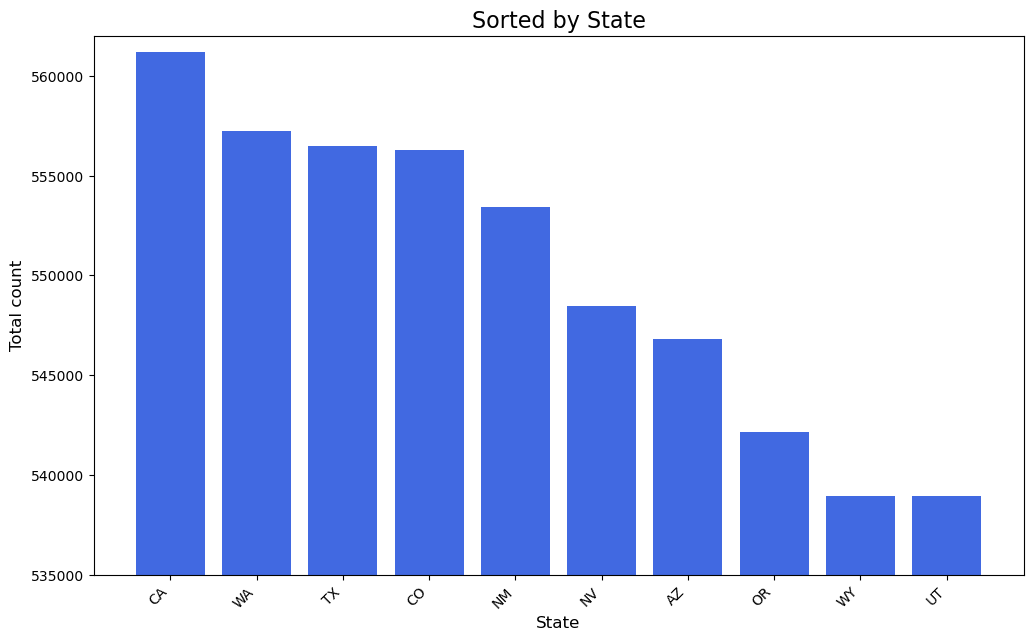

In [24]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
# 1. 데이터를 값(value) 기준으로 내림차순 정렬하여 가독성을 높입니다.
final_result.sort(key=lambda item: item[1], reverse=True)

# 2. 정렬된 데이터를 x축(레이블)과 y축(값)으로 분리합니다.
labels, values = zip(*final_result)

# 3. 막대그래프를 생성합니다.
plt.figure(figsize=(12, 7))  # 그래프 크기 설정
plt.bar(labels, values, color='royalblue') # 막대그래프 그리기

# 4. 그래프에 제목과 축 이름을 추가합니다.
plt.title('Sorted by State', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Total count', fontsize=12)
plt.ylim(535000, 562000)

# 5. x축 레이블이 겹치지 않도록 45도 회전시킵니다.
plt.xticks(rotation=45, ha='right')
plt.show()